<a href="https://colab.research.google.com/github/divya2648/CS682/blob/main/CS682_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import and Initialization**

In [115]:
!pip install pycountry

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [139]:
import pandas as pd
import requests
import json
import csv
from geopy import distance
from geopy.geocoders import Nominatim
from google.colab import drive
#Authorize access to google drive
drive.mount('/content/drive', force_remount=True)

import plotly.express as px
import plotly.graph_objects as go

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.cluster.vq import kmeans2
import matplotlib.pyplot as plt

from matplotlib.ticker import PercentFormatter

Mounted at /content/drive


In [117]:
#Dictionary to map US states to State Codes
us_state_to_abbrev = {
"Alabama": "AL",
"Alaska": "AK",
"Arizona": "AZ",
"Arkansas": "AR",
"California": "CA",
"Colorado": "CO",
"Connecticut": "CT",
"Delaware": "DE",
"Florida": "FL",
"Georgia": "GA",
"Hawaii": "HI",
"Idaho": "ID",
"Illinois": "IL",
"Indiana": "IN",
"Iowa": "IA",
"Kansas": "KS",
"Kentucky": "KY",
"Louisiana": "LA",
"Maine": "ME",
"Maryland": "MD",
"Massachusetts": "MA",
"Michigan": "MI",
"Minnesota": "MN",
"Mississippi": "MS",
"Missouri": "MO",
"Montana": "MT",
"Nebraska": "NE",
"Nevada": "NV",
"New Hampshire": "NH",
"New Jersey": "NJ",
"New Mexico": "NM",
"New York": "NY",
"North Carolina": "NC",
"North Dakota": "ND",
"Ohio": "OH",
"Oklahoma": "OK",
"Oregon": "OR",
"Pennsylvania": "PA",
"Rhode Island": "RI",
"South Carolina": "SC",
"South Dakota": "SD",
"Tennessee": "TN",
"Texas": "TX",
"Utah": "UT",
"Vermont": "VT",
"Virginia": "VA",
"Washington": "WA",
"West Virginia": "WV",
"Wisconsin": "WI",
"Wyoming": "WY",
"District of Columbia": "DC",
"American Samoa": "AS",
"Guam": "GU",
"Northern Mariana Islands": "MP",
"Puerto Rico": "PR",
"United States Minor Outlying Islands": "UM",
"U.S. Virgin Islands": "VI",
}

# **Fetch irradiance and temperature for given citites**

In [118]:
# Fetch the lat-lon file into a dataframe
df_lat_lon = pd.read_excel('/content/drive/My Drive/ColabNotebooks/inputFolder/lat-lon.xlsx')

# Add two new columns "City Name" and "State Code/Country Name"
df_lat_lon["City Name"] = pd.NaT
df_lat_lon["State Code/Country Name"] = pd.NaT

# Use geolocator to fetch city and state code (for US cities)/ country name using latitude and longitude and populate dfll dataframe
geolocator = Nominatim(user_agent='myapplication')
for index, row in df_lat_lon.iterrows():
  address = geolocator.reverse(str(row[0])+","+str(row[1])).raw['address']
  df_lat_lon.loc[index,"City Name"] = address.get('city', '')
  if address.get('country', '') == "United States":
    df_lat_lon.loc[index,"State Code/Country Name"] = us_state_to_abbrev.get(address.get('state', ''))
  else:
    df_lat_lon.loc[index,"State Code/Country Name"] = address.get('country', '')

#Drop NaT values and update the lat-lon file
df_lat_lon = df_lat_lon.dropna()

In [119]:
#fetch the city-name file into a dataframe
df_city_name = pd.read_excel('/content/drive/My Drive/ColabNotebooks/inputFolder/city-name.xlsx')

#Add two new columns "Latitude" and "Longitude"
df_city_name["Latitude"] = pd.NaT
df_city_name["Longitude"] = pd.NaT

# Use geolocator to latitude and longitude using city and state code (for US cities)/ country name and populate dfcity dataframe
geolocator = Nominatim(user_agent='myapplication')
for index, row in df_city_name.iterrows():
  location = geolocator.geocode(row[0]+","+row[1],timeout=1000)
  if not location == None:
    df_city_name.loc[index,"Latitude"]=location.latitude
    df_city_name.loc[index,"Longitude"]=location.longitude

#Drop NaT values and update the lat-lon file
df_city_name = df_city_name.dropna()

In [120]:
#Concatenate lat-lon and city-name dataframes without duplicates
df_irradiance_temp = pd.concat([df_city_name,df_lat_lon], axis = 0).drop_duplicates().reset_index(drop=True)

In [121]:
#Add four new columns "Irradiance", "Avg temp", "Max temp", and "Min temp"
df_irradiance_temp["Irradiance"] = pd.NaT
df_irradiance_temp["Avg temp"] = pd.NaT
df_irradiance_temp["Max temp"] = pd.NaT
df_irradiance_temp["Min temp"] = pd.NaT
for index,row in df_irradiance_temp.iterrows():
  #Get irradiance and temperature for all the latitude and longitude values in the dataframe
  json_data = json.loads(requests.get('https://power.larc.nasa.gov/api/temporal/monthly/point?start=2016&end=2020&latitude='+str(row[2])+'&longitude='+str(row[3])+'&community=re&parameters=ALLSKY_SFC_SW_DWN%2CT2M%2CT2M_MAX%2CT2M_MIN&format=json&header=true').text)
  irradiance = json_data['properties']['parameter']['ALLSKY_SFC_SW_DWN']
  AvgTemp = json_data['properties']['parameter']['T2M']
  maxTemp = json_data['properties']['parameter']['T2M_MAX']
  minTemp = json_data['properties']['parameter']['T2M_MIN']
  df_irradiance_temp.loc[index,"Irradiance"] = (irradiance['201613']+irradiance['201713']+irradiance['201813']+irradiance['201913']+irradiance['202013'])/5
  df_irradiance_temp.loc[index,"Avg temp"] = (AvgTemp['201613']+AvgTemp['201713']+AvgTemp['201813']+AvgTemp['201913']+AvgTemp['202013'])/5
  df_irradiance_temp.loc[index,"Max temp"] = (maxTemp['201613']+maxTemp['201713']+maxTemp['201813']+maxTemp['201913']+maxTemp['202013'])/5
  df_irradiance_temp.loc[index,"Min temp"] = (minTemp['201613']+minTemp['201713']+minTemp['201813']+minTemp['201913']+minTemp['202013'])/5

In [122]:
# Creating a new irradiance-temp.xlsx in the output folder
# df_irradiance_temp.to_excel('/content/drive/My Drive/ColabNotebooks/outputFolder/irradiance-temp.xlsx',index=False)

# **Fetch Average NO2 for given cities**

In [123]:
# Get the contents of NASA Timeseries files through URL
!wget https://so2.gsfc.nasa.gov/no2/pix/time_series/OMNO2_Timeseries_AllCities.csv -q
data = pd.read_csv('OMNO2_Timeseries_AllCities.csv',index_col=False, on_bad_lines='skip',skiprows=7)
df_average_NO2 = pd.DataFrame(data)

In [124]:
sum_med = df_average_NO2.groupby('City')['Median'].mean()

with open('OMNO2_Timeseries_AllCities.csv','r') as f_in:
    f = csv.reader(f_in)
    rows = df_average_NO2.groupby(['City','Country','LonCenter','LatCenter']).agg({'Median': ['mean']})
    rows.columns = ['Average NO2']
    rows = rows.reset_index()

for index, row in rows.iterrows():
  #Get latitude and longitude using city and state code (for US cities)/ country name 
  location = geolocator.geocode(row[0]+","+row[1],timeout=1000)
  if not location == None:
    rows.loc[index,"LatCenter"] = location.latitude
    rows.loc[index,"LonCenter"] = location.longitude

nasa_cities = rows.rename(columns={'City': 'City Name','LonCenter':'Longitude','LatCenter':'Latitude'})

In [125]:
nasa_cities = nasa_cities.apply(pd.to_numeric, errors='ignore')
df_irradiance_temp = df_irradiance_temp.apply(pd.to_numeric, errors='ignore')
df_irradiance_temp_NO2 = df_irradiance_temp
#NO2data = pd.merge(customer_cities,nasa_cities , on=['Longitude','Latitude'])
df_irradiance_temp_NO2["Average NO2"] = pd.NaT

# Check the nearest city based on latitude and longitude values
for index, row in df_irradiance_temp_NO2.iterrows():
  min_distance=float('inf')
  for nindex, nrow in nasa_cities.iterrows():
    if(distance.distance((row['Latitude'],row['Longitude']), (nrow['Latitude'],nrow['Longitude'])).miles < min_distance):
      min_distance = distance.distance((row['Latitude'],row['Longitude']), (nrow['Latitude'],nrow['Longitude'])).miles
      min_index = nindex
  df_irradiance_temp_NO2.loc[index,'Average NO2'] = nasa_cities['Average NO2'].values[min_index]

In [126]:
#Creating a new Average NO2 data in the output folder
df_irradiance_temp_NO2.to_excel('/content/drive/My Drive/ColabNotebooks/outputFolder/irradiance_temp_no2_data.xlsx',index=False)

# **Hierarchial Clustering and Non-Hierarchial Clustering**

AGGLOMERATIVE HIERARCHIAL CLUSTERING - DENDOGRAM

In [127]:
df_clustering = df_irradiance_temp_NO2.filter(items=['City Name','State Code/Country Name','Irradiance', 'Avg temp','Average NO2'])
df_clustering = df_clustering.set_index(['City Name','State Code/Country Name'])
df_clustering = df_clustering.apply(pd.to_numeric, errors='ignore')

# Normalize dataframe values
df_clustering=(df_clustering-df_clustering.min())/(df_clustering.max()-df_clustering.min())
df_clustering=df_clustering.reset_index()

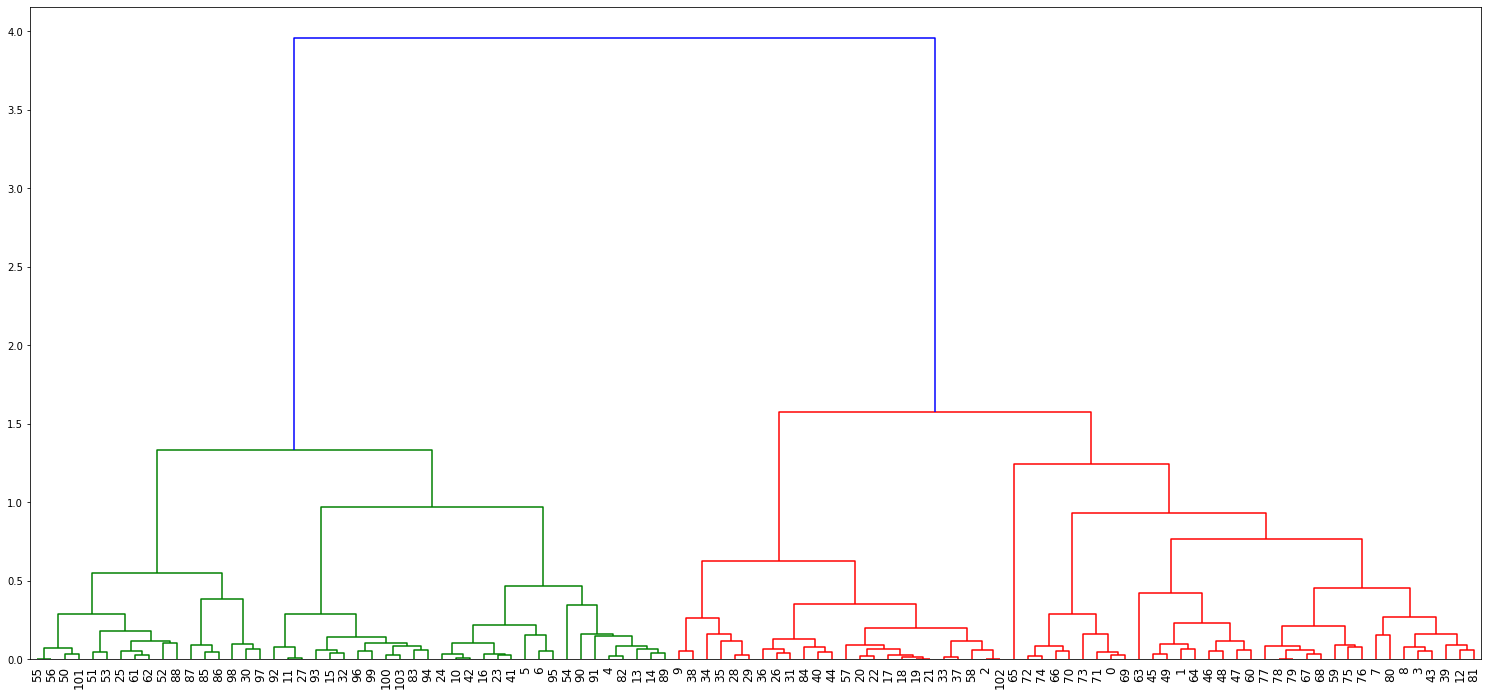

In [128]:
df_dendogram = df_clustering.set_index(['City Name','State Code/Country Name'])
Z = linkage(df_dendogram, 'ward',metric='euclidean')
plt.figure(figsize=(26,12))
dendrogram(Z,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True,
           labels = df_clustering.index,
           leaf_font_size=12)
plt.show()

SCATTER MATRIX CHARTS FOR HIERARCHIAL CLUSTERING

In [129]:
# fcluster method assigns cluster index to data categorizing into 6 clusters.
df_clustering["Cluster index"] = fcluster(Z, t=6, criterion='maxclust')

In [130]:
#3d scatter plot showing the clusters in 3d space.
scatter3dPlot = px.scatter_3d(df_clustering, x='Irradiance', y='Avg temp', z='Average NO2',
              color='Cluster index', hover_data=['City Name','State Code/Country Name',"Irradiance","Avg temp","Average NO2"])
scatter3dPlot.update(layout_coloraxis_showscale=False)
scatter3dPlot.show()

In [131]:
# 2d scatter matrix using plotly express
scatter2dPlot = px.scatter_matrix(df_clustering,
    dimensions=["Irradiance", "Avg temp", "Average NO2"],
    color="Cluster index", hover_data=['City Name','State Code/Country Name',"Irradiance","Avg temp","Average NO2"])
scatter2dPlot.update(layout_coloraxis_showscale=False)
scatter2dPlot.show()

[Text(0, 0, '0'),
 Text(0, 0, '0.2'),
 Text(0, 0, '0.4'),
 Text(0, 0, '0.6'),
 Text(0, 0, '0.8'),
 Text(0, 0, '1')]

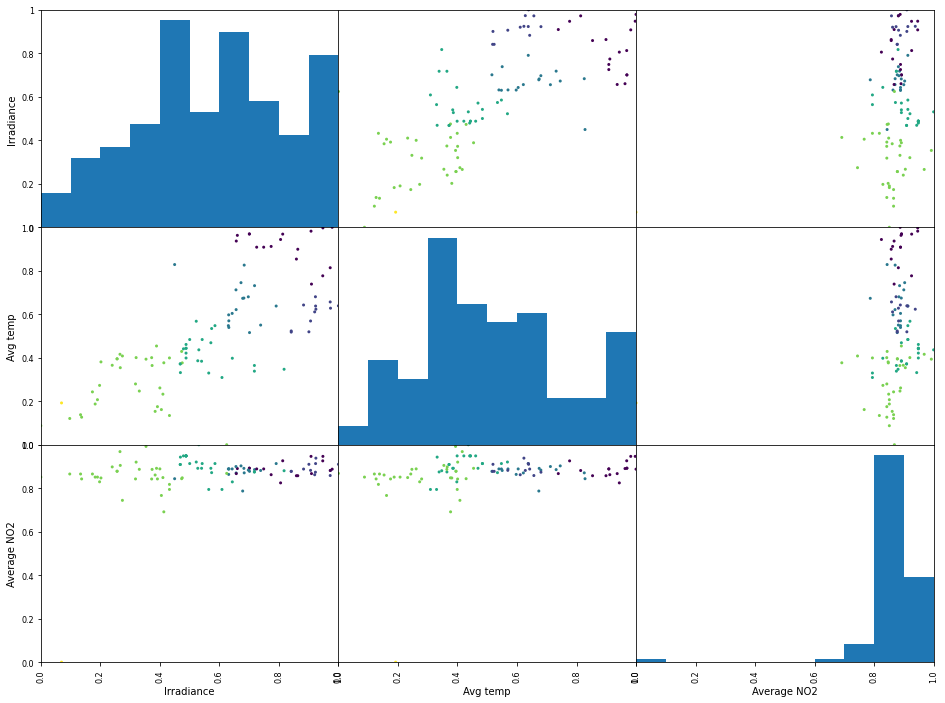

In [132]:
# Pandas scatter matrix to show the cluster patters with 6 clusters.
X = df_clustering[['Irradiance','Avg temp','Average NO2']];
y = df_clustering['Cluster index'];
# removing irregular y axis values and plotting the scatter matix
axes=pd.plotting.scatter_matrix(X,c=y,range_padding=0,alpha=2, figsize=(16,12))
axes[0,0].set_yticklabels([0,0.2,0.4,0.6,0.8,1])

NON-HIERARCHIAL CLUSTERING USING K-MEANS

In [133]:
k_count=6
df_kmeans = df_clustering.filter(items=['Irradiance','Avg temp','Average NO2'])
kviz,label = kmeans2(df_kmeans, k_count, iter=10, minit='++', missing='warn', check_finite=True)
df_clustering["Cluster index"] = label
Normalized_df=df_clustering.reset_index()

SCATTER MATRIX CHARTS FOR NON-HIERARCHIAL CLUSTERING

In [134]:
#3d scatter plot of data obtained from k-means analysis
scatter3dPlot3 = px.scatter_3d(df_clustering, x='Irradiance', y='Avg temp', z='Average NO2',
              color='Cluster index', hover_data=['City Name','State Code/Country Name',"Irradiance","Avg temp","Average NO2"])
scatter3dPlot3.update(layout_coloraxis_showscale=False)
scatter3dPlot3.show()

In [135]:
# 2d scatter matrix using plotly express for data obtained from kmeans analysis 
ScatterPlot3 = px.scatter_matrix(df_clustering,
    dimensions=["Irradiance", "Avg temp", "Average NO2"],
    color="Cluster index", hover_data=['City Name','State Code/Country Name',"Irradiance","Avg temp","Average NO2"])
ScatterPlot3.update(layout_coloraxis_showscale=False)
ScatterPlot3.show()

[Text(0, 0, '0'),
 Text(0, 0, '0.2'),
 Text(0, 0, '0.4'),
 Text(0, 0, '0.6'),
 Text(0, 0, '0.8'),
 Text(0, 0, '1')]

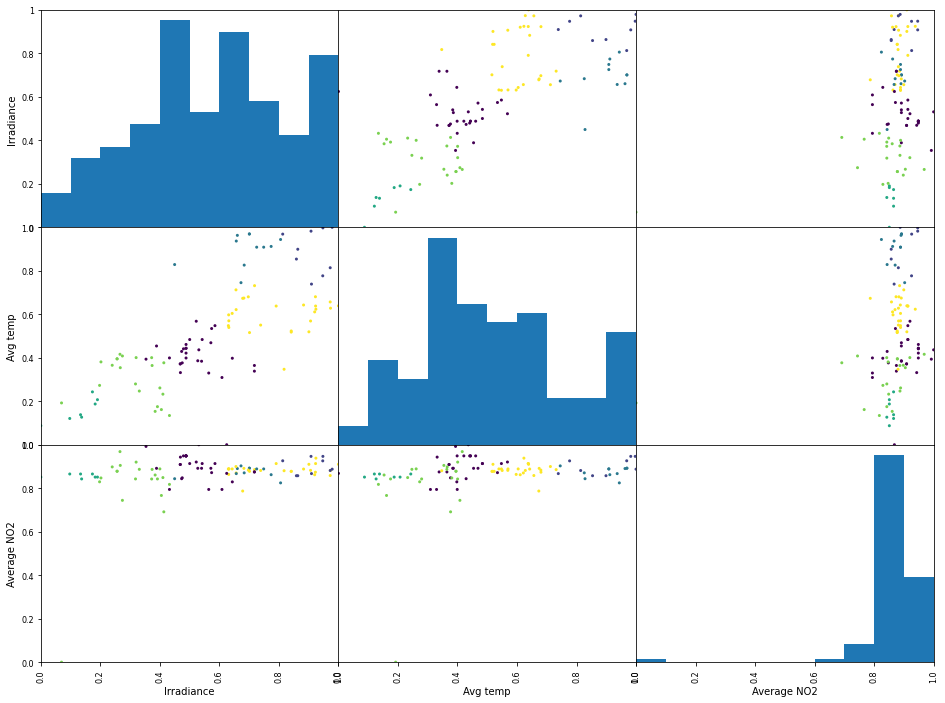

In [136]:
# Pandas scatter matrix to show the cluster patters with 2 clusters.
X = df_clustering[['Irradiance','Avg temp','Average NO2']];
y = df_clustering['Cluster index'];
# removing irregular y axis values and plotting the scatter matix
axes2=pd.plotting.scatter_matrix(X,c=y,range_padding=0,alpha=2, figsize=(16,12))
axes2[0,0].set_yticklabels([0,0.2,0.4,0.6,0.8,1])

# **Pareto comparison**

In [178]:
df_pareto = df_irradiance_temp_NO2

# Calculate DominationCount
df_pareto['DominationCount'] = 0
for i, row in df_pareto.iterrows():
    dominance = 0
    for j, row2 in df_pareto.iterrows():
        if (row2['Average NO2'] < row['Average NO2']) or (row2['Avg temp'] > row['Avg temp']) or (row2['Irradiance'] < row['Irradiance'] ):
          continue
        if (row2['Average NO2'] > row['Average NO2']) or (row2['Avg temp'] < row['Avg temp']) or (row2['Irradiance'] > row['Irradiance'] ):
          dominance += 1
    
    df_pareto.at[i, 'DominationCount'] = dominance # Output the final dominance

df_pareto=df_pareto.set_index('City Name')

Pareto Analysis on Irradiance

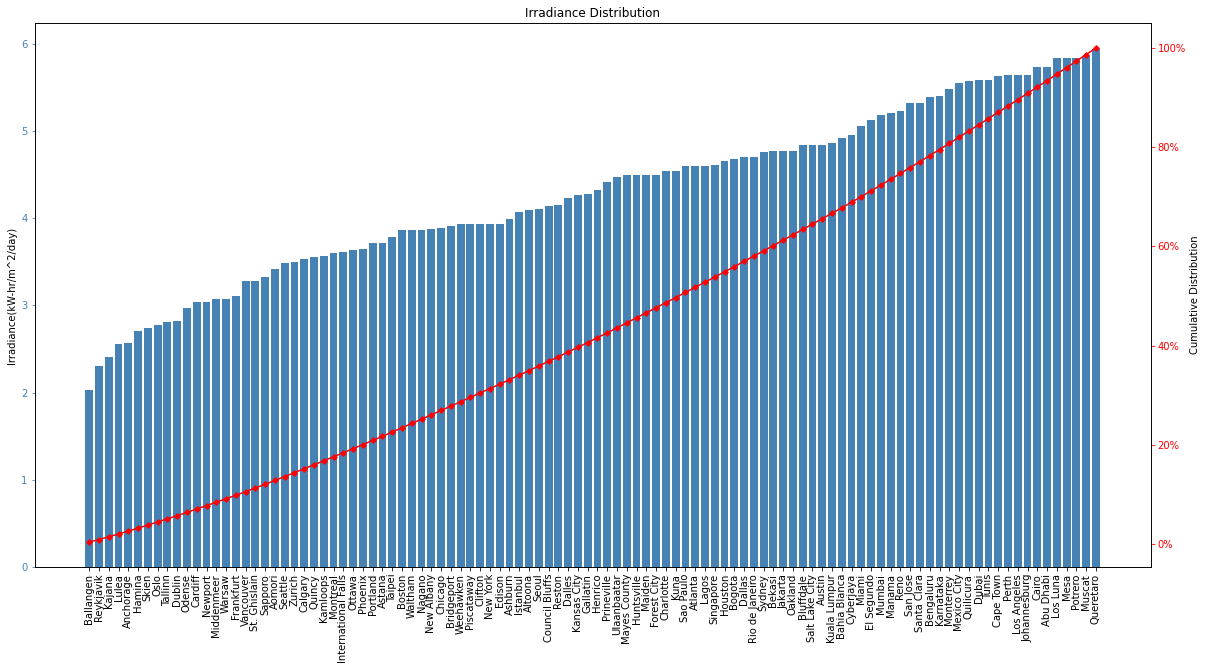

In [179]:
color1 = 'steelblue'
color2 = 'red'
line_size = 4

df_pareto = df_pareto.sort_values(by='Irradiance', ascending=True)
df_pareto['Irradiancecum'] = df_pareto['Irradiance'].cumsum()/df_pareto['Irradiance'].sum()*100
fig, ax = plt.subplots(figsize=(20,10))
ax.bar(df_pareto.index, df_pareto['Irradiance'], color=color1)
ax2 = ax.twinx()
ax2.plot(df_pareto.index, df_pareto['Irradiancecum'], color=color2, marker="D", ms=line_size)
ax2.yaxis.set_major_formatter(PercentFormatter())
ax.tick_params(axis='y', colors=color1)
ax2.tick_params(axis='y', colors=color2)

ax.set_xticklabels(df_pareto.index, rotation = 90)
plt.title("Irradiance Distribution")
ax.set_ylabel('Irradiance(kW-hr/m^2/day)')
ax2.set_ylabel('Cumulative Distribution')

plt.show()

Pareto Analysis for Average Temperature

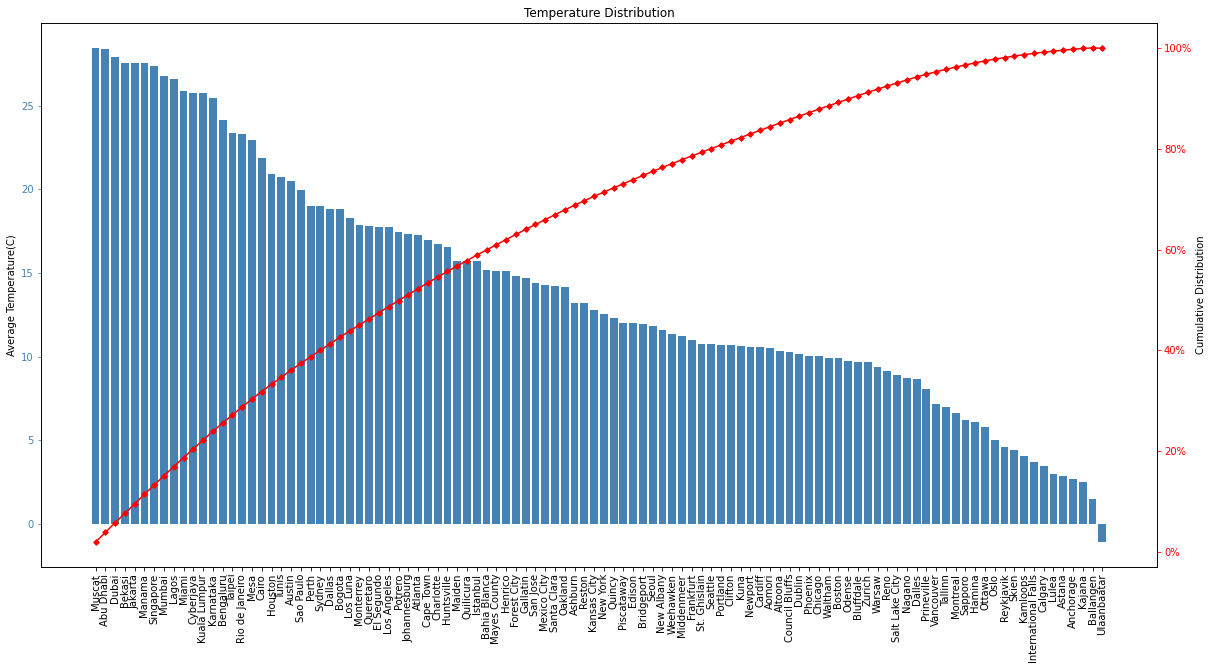

In [180]:
df_pareto = df_pareto.sort_values(by='Avg temp', ascending=False)
df_pareto['Avgtempcum'] = df_pareto['Avg temp'].cumsum()/df_pareto['Avg temp'].sum()*100

fig, ax = plt.subplots(figsize=(20,10))
ax.bar(df_pareto.index, df_pareto['Avg temp'], color=color1)
ax2 = ax.twinx()
ax2.plot(df_pareto.index, df_pareto['Avgtempcum'], color=color2, marker="D", ms=line_size)
ax2.yaxis.set_major_formatter(PercentFormatter())
ax.tick_params(axis='y', colors=color1)
ax2.tick_params(axis='y', colors=color2)

ax.set_xticklabels(df_pareto.index, rotation = 90)
plt.title("Temperature Distribution")
ax.set_ylabel('Average Temperature(C)')
ax2.set_ylabel('Cumulative Distribution')
plt.show()

Pareto Analysis for Average No2

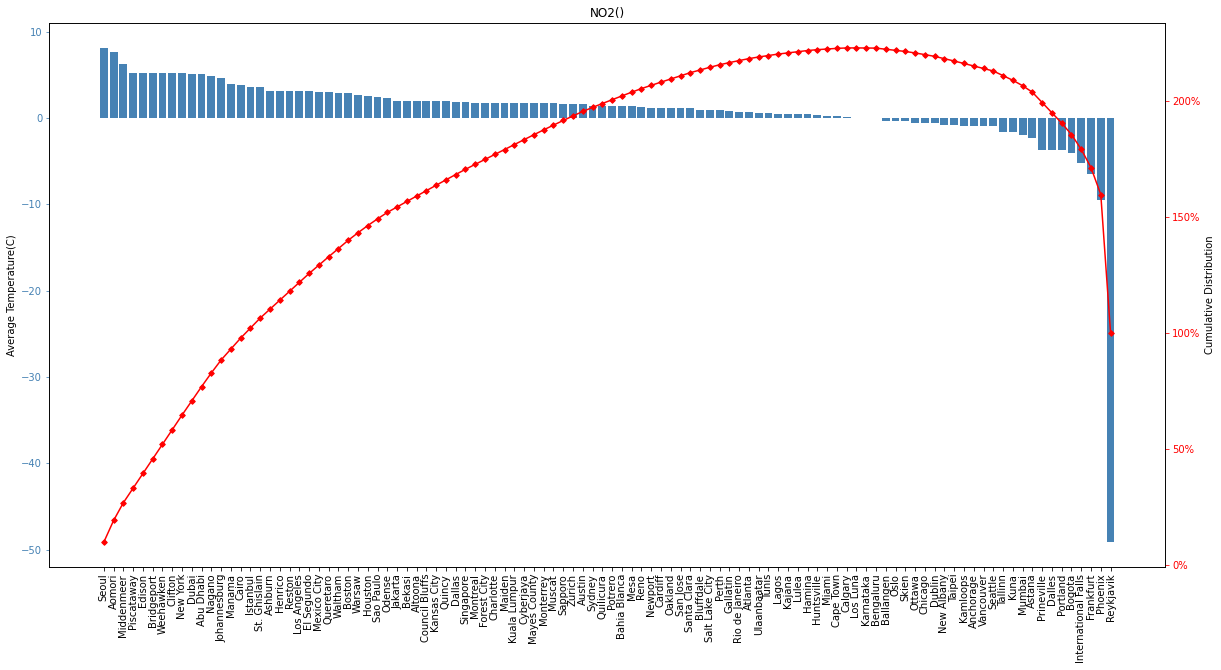

In [181]:
df_pareto = df_pareto.sort_values(by='Average NO2', ascending=False)
df_pareto['AvgNo2cum'] = df_pareto['Average NO2'].cumsum()/df_pareto['Average NO2'].sum()*100
fig, ax = plt.subplots(figsize=(20,10))
ax.bar(df_pareto.index, df_pareto['Average NO2'], color=color1)
ax2 = ax.twinx()
ax2.plot(df_pareto.index, df_pareto['AvgNo2cum'], color=color2, marker="D", ms=line_size)
ax2.yaxis.set_major_formatter(PercentFormatter())

ax.tick_params(axis='y', colors=color1)
ax2.tick_params(axis='y', colors=color2)

ax.set_xticklabels(df_pareto.index, rotation = 90)
plt.title("NO2()")
ax.set_ylabel('Average Temperature(C)')
ax2.set_ylabel('Cumulative Distribution')
plt.show()

SCATTER AND LINE CHARTS

In [182]:
# 3-D SCATTER CHART
is_0 = df_pareto['DominationCount']==0
fig = px.scatter_3d(df_pareto, x='Irradiance', y='Average NO2', z='Avg temp',
                    color='DominationCount',symbol=is_0,hover_data=[df_pareto.index,'DominationCount'])
fig.update(layout_showlegend=False)
fig.show()

In [183]:
# SCATTTER MATRIX CHARTS
df_pareto=df_pareto.sort_index()
fig = px.scatter_matrix(df_pareto,
    dimensions=["Irradiance", "Average NO2", "Avg temp"],
    color=df_pareto.index)

fig.show()

In [185]:
#POLAR SCATTER CHART
df_pareto=df_pareto.reset_index(inplace=False)
df_pareto=df_pareto.drop(columns=['DominationCount'])

df_pareto = pd.melt(df_pareto, id_vars=['City Name','Irradiancecum','Avgtempcum','AvgNo2cum'], 
                  var_name="Indicators", value_name="Value")
df_pareto=df_pareto.sort_values('City Name')
fig = px.scatter_polar(df_pareto,r='Value',
                       theta='Indicators',
                       color='City Name')
fig.show()

POLAR LINE CHART

In [186]:
# POLAR LINE CHART
fig = px.line_polar(df_pareto,r='Value',
                    theta='Indicators',
                    color='City Name',
                    line_close=True,
                    template="plotly_dark")
fig.show()

# **Bubble Map Visualization**

BUBBLE MAPS OF IRRADIANCE DATA

In [197]:
df_bubble = df_irradiance_temp_NO2

#Convert the "object" type columns to numeric to facilitate plotting
df_bubble = df_bubble.apply(pd.to_numeric, errors='ignore')

#Data to be visible on hover
df_bubble['text'] = 'City Name: '+df_bubble["City Name"]+ \
              '<br>State Code/Country Name: '+df_bubble["State Code/Country Name"]+ \
              '<br>Irradiance: '+df_bubble["Irradiance"].astype(str)+ \
              '<br>Avg temp: '+df_bubble["Avg temp"].astype(str)+ \
              '<br>Max temp: '+df_bubble["Max temp"].astype(str)+ \
              '<br>Min temp: '+df_bubble["Min temp"].astype(str)+ \
              '<br>Average NO2: '+df_bubble["Average NO2"].astype(str)
names = ["0%-10%","10%-20%","20%+"]

In [198]:
#Bubble map of the world against Irradiance data:

# Sort values on Irradiance to obtain the top 10%, 10%-20% and 20%+
df_bubble = df_bubble.sort_values(['Irradiance'], ascending=[0],ignore_index=True)
for index,row in df_bubble.iterrows():
  if index+1 <= int(len(df_bubble.index)*10/100):
    df_bubble.loc[index,'colors'] = "10%"
  elif index+1 <= int(len(df_bubble.index)*10/100)+int(len(df_bubble.index)*20/100):
    df_bubble.loc[index,'colors'] = "10-20%"
  else:
    df_bubble.loc[index,'colors'] = "20%+"
  
# Plot the bubblemap of the natural earth with Irradiance data
fig = px.scatter_geo(df_bubble, lat=df_bubble.Latitude,
                     lon=df_bubble.Longitude,
                     color_discrete_sequence=[ "red", "orange", "green"],
                     color = df_bubble['colors'],
                     hover_data=["City Name", "State Code/Country Name", "Latitude", "Longitude", "Irradiance","Avg temp","Max temp","Min temp","Average NO2"], 
                     size=df_bubble['Irradiance'],
                     projection="natural earth")
fig.show()

In [199]:
# Bubble map of the USA against Irradiance data:

# Set values for the sorted Irradiance to obtain the top 10%, 10%-20% and 20%+ and colorcode accordingly
limits = [(0,
           int(len(df_bubble.index)*10/100)),
          (int(len(df_bubble.index)*10/100),
           int(len(df_bubble.index)*10/100)+int(len(df_bubble.index)*20/100)),
          (int(len(df_bubble.index)*10/100)+int(len(df_bubble.index)*20/100),
           int(len(df_bubble.index)))]
colors = ["red","orange","green"]

#Add trace values to figure accordingly
fig = go.Figure()
for i in range(len(limits)):
    lim = limits[i]
    df_sub = df_bubble[lim[0]:lim[1]]
    fig.add_trace(go.Scattergeo(locationmode = 'USA-states', lon = df_sub['Longitude'], lat = df_sub['Latitude'], text= df_sub['text'],
        marker = dict( size = df_sub['Irradiance']*4, color = colors[i], sizemode = 'diameter' ),
        name = names[i]))

# Plot the bubblemap of the USA with Irradiance data
fig.update_layout(
        title_text = '2016 to 2020 US Irradiance<br>(Click legend to toggle traces)',
        showlegend = True,
        geo = dict(scope = 'usa', landcolor = 'rgb(217, 217, 217)')
    )
fig.show()

BUBBLE MAPS OF AVERAGE TEMPERATURE DATA

In [200]:
#Bubble map of the world against Avg Temp data:

# Sort values on Avg temp to obtain the top 10%, 10%-20% and 20%+
df_bubble = df_bubble.sort_values(['Avg temp'],ignore_index=True)
for index,row in df_bubble.iterrows():
  if index+1 <= int(len(df_bubble.index)*10/100):
    df_bubble.loc[index,'colors'] = "10%"
  elif index+1 <= int(len(df_bubble.index)*10/100)+int(len(df_bubble.index)*20/100):
    df_bubble.loc[index,'colors'] = "10-20%"
  else:
    df_bubble.loc[index,'colors'] = "20%+"
df_bubble['Absolute Avg temp'] = abs(df_bubble['Avg temp'])
df_bubble['Absolute Avg temp'] = max(df_bubble['Absolute Avg temp'])+1 - df_bubble['Absolute Avg temp']

# Plot the bubblemap of the natural earth with Avg temp data
fig = px.scatter_geo(df_bubble, lat=df_bubble.Latitude,
                     lon=df_bubble.Longitude,
                     color_discrete_sequence=[ "teal", "steelblue", "lightblue"],
                     color = df_bubble['colors'],
                     hover_data=["City Name", "State Code/Country Name", "Latitude", "Longitude", "Irradiance","Avg temp","Max temp","Min temp","Average NO2"], 
                     size=df_bubble['Absolute Avg temp'],
                     projection="natural earth")
fig.show()

In [201]:
# Bubble map of the USA against Avg temp data:

# Set values for the sorted Avg temp to obtain the top 10%, 10%-20% and 20%+ and colorcode accordingly
limits = [(0,int(len(df_bubble.index)*10/100)),
          (int(len(df_bubble.index)*10/100),int(len(df_bubble.index)*10/100)+int(len(df_bubble.index)*20/100)),
          (int(len(df_bubble.index)*10/100)+int(len(df_bubble.index)*20/100),int(len(df_bubble.index)))]
colors = ["teal", "steelblue", "lightblue"]

#Add trace values to figure accordingly
fig = go.Figure()
for i in range(len(limits)):
    lim = limits[i]
    df_sub = df_bubble[lim[0]:lim[1]]
    fig.add_trace(go.Scattergeo(locationmode = 'USA-states', lon = df_sub['Longitude'], lat = df_sub['Latitude'], text= df_sub['text'],
        marker = dict( size = df_sub['Absolute Avg temp'], color = colors[i], sizemode = 'diameter' ),
        name = names[i]))

# Plot the bubblemap of the USA with Avg temp data
fig.update_layout(
        title_text = '2016 to 2020 US Average temperature<br>(Click legend to toggle traces)',
        showlegend = True,
        geo = dict(scope = 'usa', landcolor = 'rgb(217, 217, 217)')
    )
fig.show()

BUBBLE MAPS OF AVERAGE NO2 DATA

In [202]:
#Bubble map of the world against average NO2 data:

# Sort values on Average NO2 to obtain the top 10%, 10%-20% and 20%+
df_bubble = df_bubble.sort_values(['Average NO2'],ascending=[0],ignore_index=True)
for index,row in df_bubble.iterrows():
  if index+1 <= int(len(df_bubble.index)*10/100):
    df_bubble.loc[index,'colors'] = "10%"
  elif index+1 <= int(len(df_bubble.index)*10/100)+int(len(df_bubble.index)*20/100):
    df_bubble.loc[index,'colors'] = "10-20%"
  else:
    df_bubble.loc[index,'colors'] = "20%+"


# Make all values positive and scaleable
df_bubble['Absolute Average NO2'] = abs(df_bubble['Average NO2'])
df_bubble['Absolute Average NO2'] = df_bubble['Average NO2'] + max(df_bubble['Absolute Average NO2'])+1


# Plot the bubblemap of the natural earth with Average NO2 data
fig = px.scatter_geo(df_bubble, lat=df_bubble.Latitude,
                     lon=df_bubble.Longitude,
                     color_discrete_sequence=[ "Brown", "BurlyWood", "Wheat"],
                     color = df_bubble['colors'],
                     hover_data=["City Name", "State Code/Country Name", "Latitude", "Longitude", "Irradiance","Avg temp","Max temp","Min temp","Average NO2"],  
                     size=df_bubble['Absolute Average NO2'],
                     projection="natural earth")
fig.show()

In [203]:
# Bubble map of the USA against Average NO2 data:

# Set values for the sorted Average NO2 to obtain the top 10%, 10%-20% and 20%+ and colorcode accordingly
limits = [(0,int(len(df_bubble.index)*10/100)),
          (int(len(df_bubble.index)*10/100),int(len(df_bubble.index)*10/100)+int(len(df_bubble.index)*20/100)),
          (int(len(df_bubble.index)*10/100)+int(len(df_bubble.index)*20/100),int(len(df_bubble.index)))]
colors = ["Brown", "BurlyWood", "Wheat"]

#Add trace values to figure accordingly
fig = go.Figure()
for i in range(len(limits)):
    lim = limits[i]
    df_sub = df_bubble[lim[0]:lim[1]]
    fig.add_trace(go.Scattergeo(locationmode = 'USA-states', lon = df_sub['Longitude'], lat = df_sub['Latitude'], text= df_sub['text'],
        marker = dict( size = df_sub['Absolute Average NO2']/2, color = colors[i], sizemode = 'diameter' ),
        name = names[i]))

# Plot the bubblemap of the USA with Average NO2 data
fig.update_layout(
        title_text = '2016 to 2020 US Average NO2<br>(Click legend to toggle traces)',
        showlegend = True,
        geo = dict(scope = 'usa', landcolor = 'rgb(217, 217, 217)')
    )
fig.show()

BUBBLE MAPS OF DHI (Datacenter Hotspot Index)

In [205]:
# Add Normalized irradiance, Normalized avg temp, Normalized NO2, and DHI columns to the dataframe
df_bubble["Normalized irradiance"] = pd.NaT
df_bubble["Normalized avg temp"] = pd.NaT
df_bubble["Normalized NO2"] = pd.NaT
df_bubble["DHI"] = pd.NaT
a=b=c=1.0

#Calculate and assign the data in the newly added columns of the dataframe
for index, row in df_bubble.iterrows():
  df_bubble.loc[index,"Normalized irradiance"] = df_bubble["Irradiance"][index] / ( max(df_bubble["Irradiance"]) - min(df_bubble["Irradiance"]) )
  df_bubble.loc[index,"Normalized avg temp"] = 1-( (df_bubble["Avg temp"][index] - min(df_bubble["Avg temp"]) ) / ( max(df_bubble["Avg temp"]) - min(df_bubble["Avg temp"]) ))
  df_bubble.loc[index,"Normalized NO2"] = (df_bubble["Average NO2"][index] - min(df_bubble["Average NO2"]) )/ ( max(df_bubble["Average NO2"]) - min(df_bubble["Average NO2"]) )
  df_bubble.loc[index,"DHI"] = ( a * df_bubble["Normalized irradiance"][index] + b * df_bubble["Normalized avg temp"][index] + c * df_bubble["Normalized NO2"][index] ) / 3

#Convert the "object" type columns to numeric to facilitate plotting
df_bubble = df_bubble.apply(pd.to_numeric, errors='ignore')

#Data to be visible on hover
df_bubble['text'] = 'City Name: '+df_bubble["City Name"]+ \
              '<br>State Code/Country Name: '+df_bubble["State Code/Country Name"]+ \
              '<br>DHI: '+df_bubble["DHI"].astype(str)+ \
              '<br>Irradiance: '+df_bubble["Irradiance"].astype(str)+ \
              '<br>Avg temp: '+df_bubble["Avg temp"].astype(str)+ \
              '<br>Max temp: '+df_bubble["Max temp"].astype(str)+ \
              '<br>Min temp: '+df_bubble["Min temp"].astype(str)+ \
              '<br>Average NO2: '+df_bubble["Average NO2"].astype(str)

In [206]:
#Bubble map of the world against DHI data:

# Sort values on DHI to obtain the top 10%, 10%-20% and 20%+
df_bubble = df_bubble.sort_values(['DHI'], ascending=[0],ignore_index=True)
for index,row in df_bubble.iterrows():
  if index+1 <= int(len(df_bubble.index)*10/100):
    df_bubble.loc[index,'colors'] = "10%"
  elif index+1 <= int(len(df_bubble.index)*10/100)+int(len(df_bubble.index)*20/100):
    df_bubble.loc[index,'colors'] = "10-20%"
  else:
    df_bubble.loc[index,'colors'] = "20%+"

# Plot the bubblemap of the natural earth with DHI data
fig = px.scatter_geo(df_bubble, lat=df_bubble.Latitude,
                     lon=df_bubble.Longitude,
                     color_discrete_sequence=[ "darkgreen", "limegreen", "yellowgreen"],
                     color = df_bubble['colors'],
                     hover_data=["City Name", "State Code/Country Name", "Irradiance","Avg temp","Max temp","Min temp","Average NO2"], 
                     size=df_bubble['DHI'],
                     projection="natural earth")
fig.show()

In [207]:
# Bubble map of the USA against DHI data:
              
# Set values for the sorted DHI to obtain the top 10%, 10%-20% and 20%+ and colorcode accordingly
limits = [(0,int(len(df_bubble.index)*10/100)),
          (int(len(df_bubble.index)*10/100),int(len(df_bubble.index)*10/100)+int(len(df_bubble.index)*20/100)),
          (int(len(df_bubble.index)*10/100)+int(len(df_bubble.index)*20/100),int(len(df_bubble.index)))]
colors = ["darkgreen", "limegreen", "yellowgreen"]

#Add trace values to figure accordingly
fig = go.Figure()
for i in range(len(limits)):
    lim = limits[i]
    df_sub = df_bubble[lim[0]:lim[1]]
    fig.add_trace(go.Scattergeo(locationmode = 'USA-states', lon = df_sub['Longitude'], lat = df_sub['Latitude'], text= df_sub['text'],
        marker = dict( size = df_sub['DHI']*30, color = colors[i], sizemode = 'diameter' ),
        name = names[i]))

# Plot the bubblemap of the USA with DHI data
fig.update_layout(
        title_text = '2016 to 2020 US Datacenter Hotspot Index<br>(Click legend to toggle traces)',
        showlegend = True,
        geo = dict(scope = 'usa', landcolor = 'rgb(217, 217, 217)')
    )
fig.show()